In [47]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, \
NthOrderBoundaryCondition, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer,PowerLawConvectionTerm,ImplicitSourceTerm
from fipy.tools import numerix
from fipy import DefaultSolver
import numpy as np
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import math

In [48]:
def solution(x, t, m, D,E):
    return np.maximum((D - E*(x - c*t))**(1/(m-1)),0)

In [49]:
def ic_func(x):
                  
    return solution(x, t0, m, D,E) # analytic Barenblatt at t0

In [50]:
L = 15.
T = 1.
nx = 2000
c= 1
dx = 2*L/nx
dt = 0.5*dx**2
mesh = Grid1D(nx=nx, dx=dx) - [[L]]
E = 1
D = 1
m = 2
t0 = 0.00
valueLeft = 0
valueRight = 0
timeStepDuration = dt
steps = int(T/dt)+1

In [51]:
x = mesh.cellCenters[0]
IC = ic_func(x)
phi = CellVariable(name="solution variable",
                   mesh=mesh,
                   value=IC,
                   hasOld = True)


phi.constrain(valueLeft,where=mesh.facesLeft)
phi.constrain(valueRight, where= mesh.facesRight)


eqX = (TransientTerm(coeff = 1)
      == DiffusionTerm(coeff = m*phi**(m-1)) )


time_var = Variable(0.0)
phi.constrain(solution(-L,time_var,m,D,E),where=mesh.facesLeft)
phi.constrain(solution(L,time_var,m,D,E), where= mesh.facesRight) 


from builtins import range
solver = DefaultSolver()


In [52]:
U_fem = []
U_exact = []

for step in range(steps):
   
    
    time_var.setValue(t0+timeStepDuration*step)
    U_fem.append(np.array(phi))
    
    npx = torch.from_numpy(np.array(x))
    
    U_exact.append(solution(npx,t0+timeStepDuration*step,m,D,E))
    phi.updateOld()
    
    eqX.solve(var=phi,
              dt=timeStepDuration,
              #boundaryConditions = BCs,
              solver = solver)
    

/tmp/ipykernel_12650/23439646.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.maximum((D - E*(x - c*t))**(1/(m-1)),0)


In [53]:
U_exact = np.array(U_exact)
U_fem = np.array(U_fem)

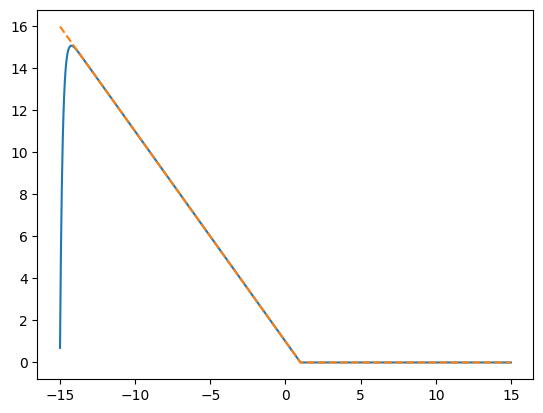

In [54]:
plt.plot(np.array(x), U_fem[1])
plt.plot(np.array(x), U_exact[1], linestyle = '--')

15.996671896799704
16.555380984878504



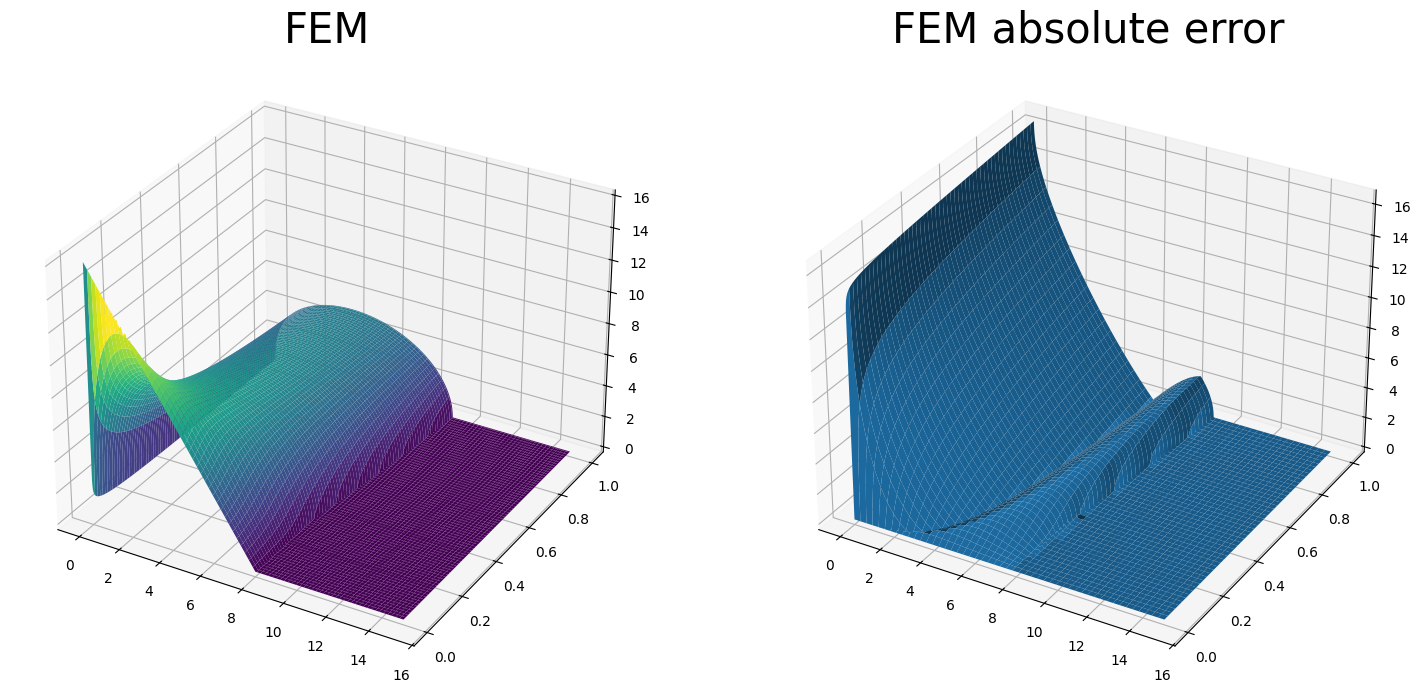

In [55]:
import matplotlib.pyplot as plt
Ts = np.linspace(0,T,steps)
Xs = np.linspace(0,L,nx)
XX,TT = np.meshgrid(Xs,Ts)
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(1,2,1, projection = '3d')

ax.plot_surface(XX,TT,U_fem,rcount=80, ccount=80, cmap="viridis", edgecolor="none")
ax.set_title('FEM', fontsize = 30)
ax = fig.add_subplot(1,2,2, projection = '3d')

ax.set_title('FEM absolute error', fontsize = 30)
ax.plot_surface(XX,TT,np.abs(U_fem - U_exact))
print(np.mean(np.mean((U_fem - U_exact)**2)))
print(np.max(np.abs(U_fem - U_exact)))
print()